In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-09-07 11:32:38.206193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:32:38.207378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:32:38.208101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:32:38.210019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [4]:
import os
os.listdir('/kaggle/lib/kaggle')

['gcp.py']

In [5]:
df = pd.read_csv('/kaggle/input/machinegenv2/train_auto_gen.csv')
df.head()

,review,auto_gen_label
0,the best sound track. I have even given my ga...,Positive
1,and will never grow old. Every time I listen ...,Positive
2,part of my soundtrack for years. I was so hap...,Positive
3,NaN,Positive
4,"amphase, and Goliath's Roar. The atmosphere of...",Positive


In [6]:
df = df.dropna()

In [7]:
print(df)

                                                review  auto_gen_label
0     the best sound track. I have even given my ga...        Positive
1     and will never grow old. Every time I listen ...        Positive
2     part of my soundtrack for years. I was so hap...        Positive
4    amphase, and Goliath's Roar. The atmosphere of...        Positive
5    akings of the game. It's not the best RPG ever...        Positive
..                                                 ...             ...
994                                                  i        Positive
995  Poor quality: I purchased this item to wear po...        Negative
997  Squeem Perfect Waist, Firm compression: I'm a ...        Negative
998   waist. It is comfortable, but it does not hav...        Positive
999  Not the best shaper: This would be great if it...        Negative

[901 rows x 2 columns]


In [8]:
print(df[' review'])

0       the best sound track. I have even given my ga...
1       and will never grow old. Every time I listen ...
2       part of my soundtrack for years. I was so hap...
4      amphase, and Goliath's Roar. The atmosphere of...
5      akings of the game. It's not the best RPG ever...
                             ...                        
994                                                    i
995    Poor quality: I purchased this item to wear po...
997    Squeem Perfect Waist, Firm compression: I'm a ...
998     waist. It is comfortable, but it does not hav...
999    Not the best shaper: This would be great if it...
Name:  review, Length: 901, dtype: object


In [9]:
X_data = df[[' review']].to_numpy().reshape(-1)
y_data = df[[' auto_gen_label']].to_numpy().reshape(-1)

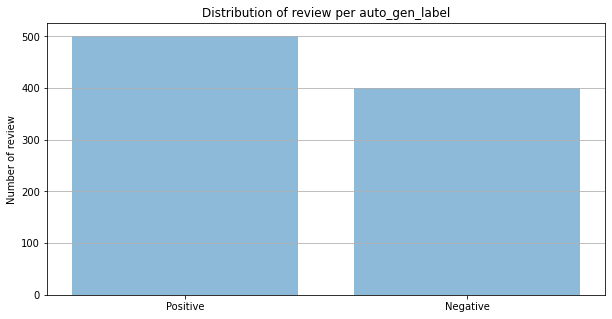

Counter({'Positive': 501, 'Negative': 400})


In [10]:
categories = df[[' auto_gen_label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of review')
plt.title('Distribution of review per auto_gen_label')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [11]:
def calculate_stats(df, split_char=' '):
    categories = df[' auto_gen_label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row[' review']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row[' auto_gen_label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df[' auto_gen_label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [12]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
Positive,"[153, 72, 40, 53, 140, 199, 56, 71, 26, 10, 29...",105.590818,73.366820
Negative,"[116, 100, 87, 114, 20, 36, 40, 64, 98, 62, 56...",80.490000,37.333959


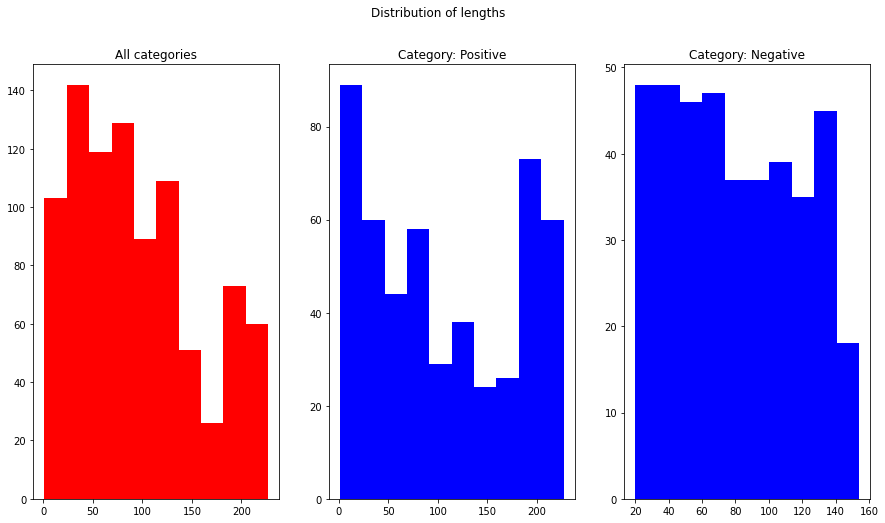

In [13]:
display_lengths_histograms(df_stats)

In [14]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df[' auto_gen_label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 901
Number of categories: 2
Done!


In [15]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') 

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [16]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'Positive', 1: 'Negative'}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=777) # random_state to reproduce results

In [18]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [20]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [21]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [22]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3


2022-09-07 11:33:27.637061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


90/90 [==============================] - 38s 325ms/step - loss: 0.2684 - accuracy: 0.8750 - val_loss: 0.0114 - val_accuracy: 0.9945
Epoch 2/3
90/90 [==============================] - 27s 295ms/step - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.0197 - val_accuracy: 0.9890
Epoch 3/3
90/90 [==============================] - 27s 295ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9945


In [23]:
import sys, time
print("The Procees Started\n") 
print("Downloading your data..... ")
    
for i in range(20):
    print(((i*100)/19),end='\r')
    
    
    
    time.sleep(1)

The Procees Started



In [24]:
dftest = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv')
dftest.head()

,review,auto_gen_label
0,\n\nJulia Child at her absolute best!!!!: This...,Positive
1,Julia Child at her absolute best!!!!: This is ...,Negative
2,e... Read more,Positive
3,This DVD is not as represented in the descript...,Negative
4,io\n\nI'm sorry to hear that you received a da...,Positive


In [25]:
dftest['review']

0      \n\nJulia Child at her absolute best!!!!: This...
1      Julia Child at her absolute best!!!!: This is ...
2                                         e... Read more
3      This DVD is not as represented in the descript...
4      io\n\nI'm sorry to hear that you received a da...
                             ...                        
195    Worth the Purchase if You Own an HDTV: I bough...
196    \n\n\n\nHulk: Yeah, I know what you mean. I've...
197    Spider-Fan: I cant wait to get this movie on B...
198    Mac, I expect to receive it in new condition.\...
199    Poor quality of wrapping: I received my "new" ...
Name: review, Length: 200, dtype: object

In [26]:
dftest = dftest.dropna()

In [27]:
print(dftest)

                                                review auto_gen_label
0    \n\nJulia Child at her absolute best!!!!: This...       Positive
1    Julia Child at her absolute best!!!!: This is ...       Negative
2                                       e... Read more       Positive
3    This DVD is not as represented in the descript...       Negative
4    io\n\nI'm sorry to hear that you received a da...       Positive
..                                                 ...            ...
195  Worth the Purchase if You Own an HDTV: I bough...       Negative
196  \n\n\n\nHulk: Yeah, I know what you mean. I've...       Positive
197  Spider-Fan: I cant wait to get this movie on B...       Negative
198  Mac, I expect to receive it in new condition.\...       Positive
199  Poor quality of wrapping: I received my "new" ...       Negative

[179 rows x 2 columns]


In [28]:
X_data = dftest[['review']].to_numpy().reshape(-1)
y_data = dftest[['auto_gen_label']].to_numpy().reshape(-1)

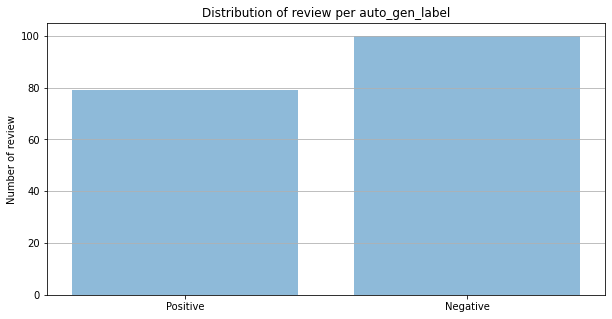

Counter({'Negative': 100, 'Positive': 79})


In [29]:
categories = dftest[['auto_gen_label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of review')
plt.title('Distribution of review per auto_gen_label')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [30]:
def calculate_statstest(df, split_char=' '):
    categories = df['auto_gen_label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['review']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['auto_gen_label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['auto_gen_label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [31]:
df_stats = calculate_statstest(dftest)
df_stats['per_category']

,lengths,mean,stdev
Positive,"[81, 3, 41, 78, 193, 8, 42, 16, 41, 3, 112, 20...",101.670886,75.996579
Negative,"[93, 81, 138, 50, 78, 40, 92, 65, 131, 37, 65,...",75.150000,33.845870


In [32]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = dftest['auto_gen_label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 179
Number of categories: 2
Done!


In [33]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id


category_to_name

{0: 'Positive', 1: 'Negative'}

In [34]:
X_test = roberta_encode(X_data, tokenizer)



y_test = np.asarray(y_data, dtype='int32')

In [35]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 2s 322ms/step - loss: 0.1453 - accuracy: 0.9832


[0.14532461762428284, 0.9832402467727661]

In [36]:
from sklearn.metrics import confusion_matrix,classification_report

In [37]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

[[0.975      0.01010101]
 [0.025      0.98989899]]


In [38]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       0.99      0.98      0.98       100

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



In [39]:
print(y_test)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1]


Longformer pretrained